In [76]:
from torchvision.models import resnet50, ResNet50_Weights
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import matplotlib.pyplot as plt
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
import pandas as pd
from utils.visualise import visualize_layer_weights
from models.mnist_conv import mnist_conv
from models.aux_funs import net_sparsity
import torchvision.transforms as T
import torchvision.models as models
import scipy
from FullGrad.saliency.fullgrad import FullGrad
from FullGrad.saliency.simple_fullgrad import SimpleFullGrad
from FullGrad.saliency.smooth_fullgrad import SmoothFullGrad

import numpy as np

In [77]:
# Preprocess the image
def preprocess(image, size=28):
    transform = T.Compose([
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))
    
def show_saliency(X, model):
    # preprocess the image
    X.requires_grad_()
    scores = model(X)[0]
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[score_max_index]

    score_max.backward()

    saliency, _ = torch.max(X.grad.data.abs(),dim=1)
    
    # code to plot the saliency map as a heatmap
    plt.imshow(X.grad.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()
    
def get_batch(loader):
    for data, target in loader:
        return data, target

In [83]:
random_seed = 2
cf.seed_torch(random_seed)
sparse_weights_path = '../checkpoints/redo_linbreg_2pc_lambda_4.pth'
sparse_2_weights_path = '../checkpoints/mnist_conv_sparse_linbreg_ggmodel_lambda_5_5pc.pth'
dense_weights_path = '../checkpoints/mnist_conv_dense.pth'
conf_args = {#
    # data specification
    'data_file':"../../Data",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':0, 'cuda_device':0, 'pin_memory':True,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.07, 'lamda_0':0.4, 'lamda_1':0.4, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,1,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
    'batch_size': 1000
}

conf = cf.Conf(**conf_args)

In [84]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

sparse_model = mnist_conv(**model_kwargs).to(conf.device)
sparse_model_weights = torch.load(sparse_weights_path, map_location=conf.device)
sparse_model.load_state_dict(sparse_model_weights)

sparse_2_model = mnist_conv(**model_kwargs).to(conf.device)
sparse_2_model_weights = torch.load(sparse_2_weights_path, map_location=conf.device)
sparse_2_model.load_state_dict(sparse_2_model_weights)

dense_model = mnist_conv(**model_kwargs).to(conf.device)
dense_model_weights = torch.load(dense_weights_path, map_location=conf.device)
dense_model.load_state_dict(dense_model_weights)

FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/mnist_conv_sparse_linbreg_ggmodel_lambda_4.pth'

In [85]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

In [81]:
data, target = get_batch(test_loader)

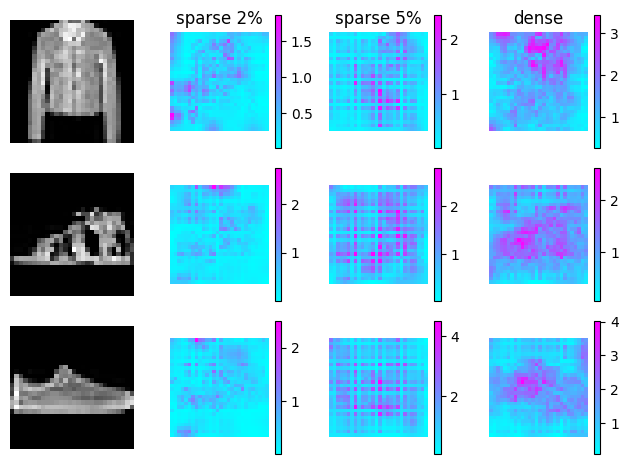

In [82]:
models = [sparse_model, sparse_2_model, dense_model]
model_names = ['sparse 2%', 'sparse 5%','dense']

fullgrads = [FullGrad(model, im_size=(1, 28, 28)) for model in models]

imgs = data.to(conf.device).requires_grad_()

maps = [fullgrad.saliency(imgs) for fullgrad in fullgrads]

iss = [10, 11, 12]

fig, axes = plt.subplots(3, len(models) + 1, sharex=True, sharey=True)

for i, index in enumerate(iss):
    img = imgs[index]
    axes[i, 0].imshow(img.detach().numpy().reshape(28,28), cmap='gray')
    axes[i, 0].axis('off')
    for j, map in enumerate(maps):
        im = axes[i, j + 1].imshow(map[index].detach().numpy().reshape(28,28), cmap='cool')
        axes[i, j + 1].axis('off')
        plt.colorbar(im)
        
        if i == 0:
            axes[i, j + 1].set_title(model_names[j])

plt.tight_layout()
plt.savefig('../images/saliency.png')
plt.show()


torch.Size([1000, 1, 28, 28])


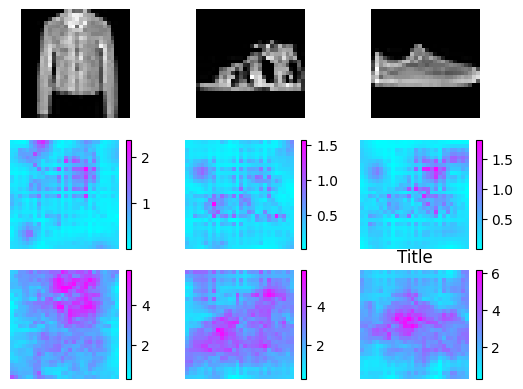

In [41]:
sparse_fullgrad = SimpleFullGrad(sparse_model, im_size=(1, 28, 28))
dense_fullgrad = SimpleFullGrad(dense_model, im_size=(1, 28, 28))

imgs = data.to(conf.device).requires_grad_()
print(imgs.shape)

sparse_maps = sparse_fullgrad.saliency(imgs)
dense_maps = dense_fullgrad.saliency(imgs)

iss = [10, 11, 12]

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)

for i, index in enumerate(iss):
    img = imgs[index]
    sparse = sparse_maps[index]
    dense = dense_maps[index]
    ax[0, i].imshow(img.detach().numpy().reshape(28,28), cmap='gray')
    ax[0, i].axis('off')
    im1 = ax[1, i].imshow(sparse.detach().numpy().reshape(28,28), cmap='cool')
    ax[1, i].axis('off')
    plt.colorbar(im1)
    im2 = ax[2, i].imshow(dense.detach().numpy().reshape(28,28), cmap='cool')
    ax[2, i].axis('off')
    plt.colorbar(im2)

plt.show()


# for i in iss:
#     plt.imshow(imgs[i].detach().numpy().reshape(28,28), cmap='gray')
#     plt.axis('off')
#     plt.show()
#     
#     plt.imshow(maps[i].detach().numpy().reshape(28,28), cmap='cool')
#     plt.axis('off')
#     plt.colorbar()
#     plt.show()

In [ ]:
# # we would run the model in evaluation mode
# model.eval()
# img = data[0].unsqueeze(0).to(conf.device)
# plt.imshow(img.reshape(28, 28), cmap='gray')
# plt.axis('off')
# plt.show()
# 
# show_saliency(img, model)
# # for img in data:
# #     show_saliency(img, model)